In [1]:
import numpy as np
import skimage as ski
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, data
import cv2
from PIL import Image
import scipy.misc
import math
import skimage.morphology as morph
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
import bisect
from matplotlib import cm
import tkinter
import tensorflow as tf

### BLEND IMAGES OF DIFFERENT SIZES

In [2]:
img2 = cv2.imread("C:/Users/naresh/Downloads/Temp Images/Do not Copy.png")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img1 = cv2.imread("C:/Users/naresh/Downloads/Temp Images/f1.jpg")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [ ]:
img2 = cv2.resize(img2, (600,600))

In [ ]:
xOff = img1.shape[1]-img2.shape[1]
yOff = img1.shape[0] - img2.shape[0]

In [ ]:
roi = img1[yOff:img1.shape[0], xOff:img1.shape[1]]

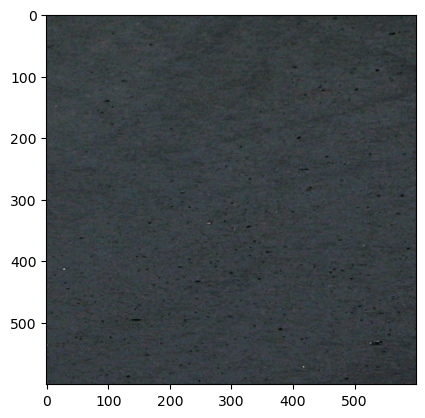

In [ ]:
plt.imshow(roi)

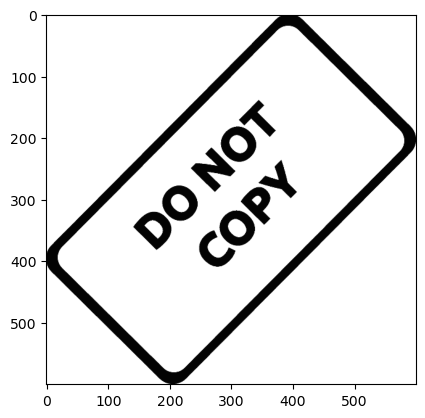

In [ ]:
img2gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
plt.imshow(img2gray, cmap='gray')

In [ ]:
maskInv = cv2.bitwise_not(img2gray)

In [ ]:
#convert to 3 channel black and white
whiteBack = np.full(img2.shape, 255, dtype=np.uint8)
bk = cv2.bitwise_or(whiteBack, whiteBack, mask = maskInv)

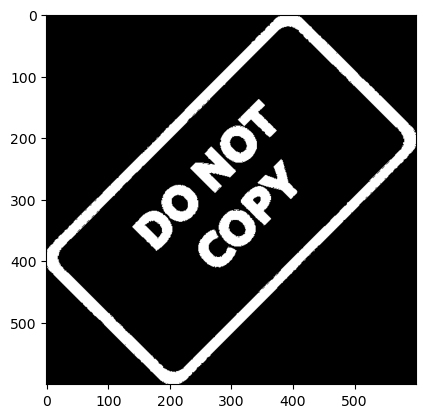

In [ ]:
plt.imshow(bk)

In [ ]:
fg = cv2.bitwise_or(img2, img2, mask=maskInv)

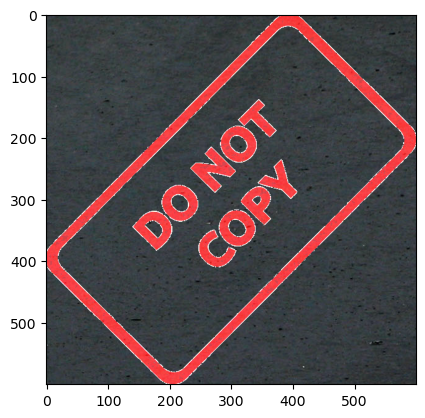

In [ ]:
finalRoi =  cv2.bitwise_or(roi, fg)
plt.imshow(finalRoi)

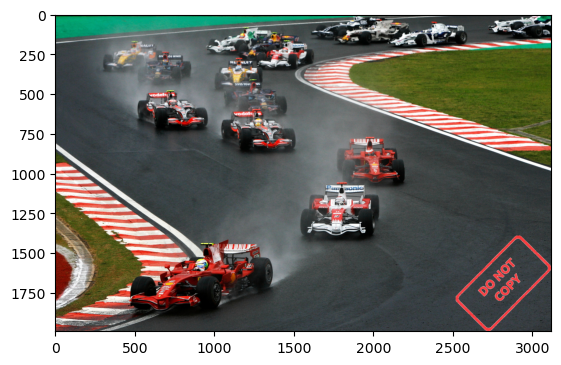

In [ ]:
largeImg = img1
smallImg = finalRoi
largeImg[yOff:yOff+smallImg.shape[0], xOff:xOff+smallImg.shape[1]] = smallImg
plt.imshow(largeImg)

### Histogram Equalization: Adding contrast to images-- spreads hist between 0 and 255

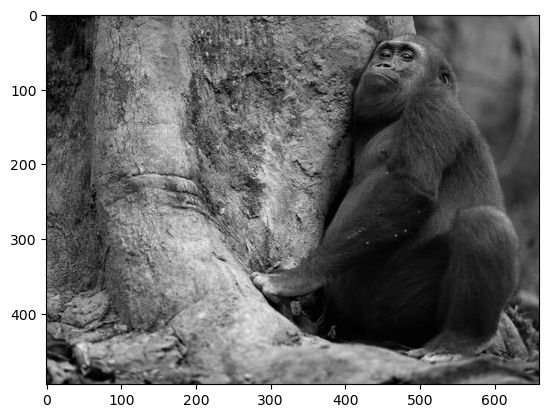

In [ ]:
gorilla = cv2.imread("C:/Users/naresh/Downloads/Temp Images/gorilla.jpg", 0)
plt.imshow(gorilla, cmap='gray')

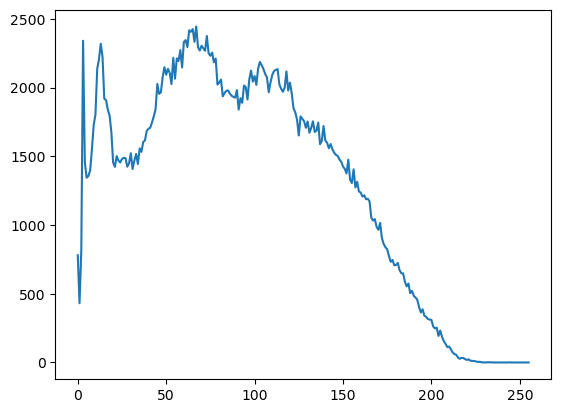

In [ ]:
histVal = cv2.calcHist([gorilla],channels=[0],mask=None,histSize=[256],ranges=[0,256])
plt.plot(histVal)

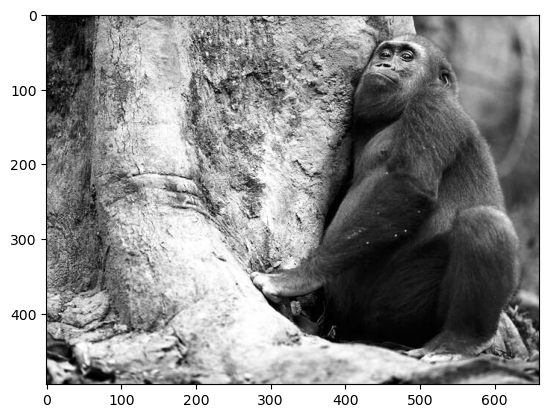

In [ ]:
eqGor = cv2.equalizeHist(gorilla)
plt.imshow(eqGor, cmap='gray')

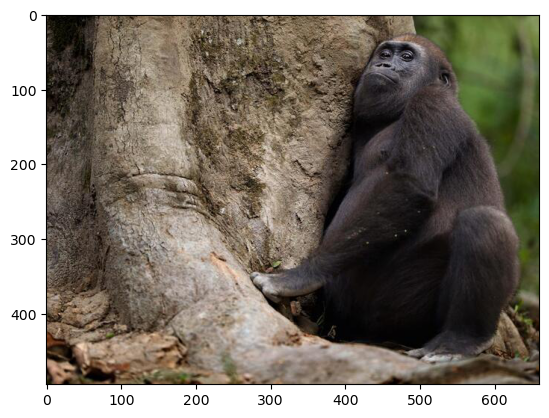

In [ ]:
gorilla = cv2.imread("C:/Users/naresh/Downloads/Temp Images/gorilla.jpg")
gorillaDisp = cv2.cvtColor(gorilla, cv2.COLOR_BGR2RGB)
plt.imshow(gorillaDisp)

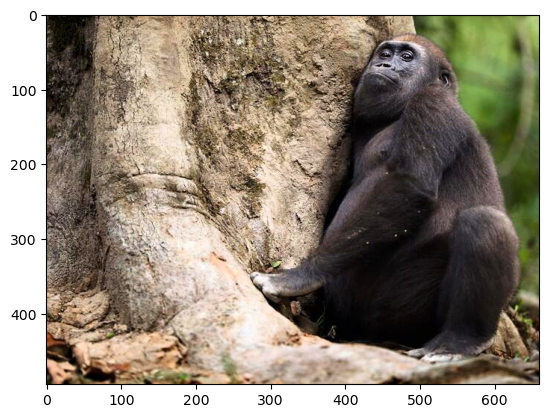

In [ ]:
gorillaHSV = cv2.cvtColor(gorilla, cv2.COLOR_BGR2HSV)
gorillaHSV[:,:,2] = cv2.equalizeHist(gorillaHSV[:,:,2])
hsvDisp = cv2.cvtColor(gorillaHSV,cv2.COLOR_HSV2RGB)
plt.imshow(hsvDisp)

### Corner Detection: Shi-Thomasi

In [ ]:
flatChess = cv2.imread("W:/Advanced Engineering/Vortex Ballistics/~ACTIVE/Python Script/DATA/flat_chessboard.png")
flatChess = cv2.cvtColor(flatChess, cv2.COLOR_BGR2RGB)
realChess = cv2.imread("W:/Advanced Engineering/Vortex Ballistics/~ACTIVE/Python Script/DATA/real_chessboard.jpg")
realChess = cv2.cvtColor(realChess, cv2.COLOR_BGR2RGB)

In [ ]:
grayFlat = cv2.cvtColor(flatChess, cv2.COLOR_BGR2GRAY)
grayReal = cv2.cvtColor(realChess, cv2.COLOR_BGR2GRAY)

In [ ]:
# (img, # of corners we want func to return or -1 for all, use default 0.01, use default 10)
corners = cv2.goodFeaturesToTrack(grayFlat, 1000, 0.01, 10)
corners = np.intp(corners)

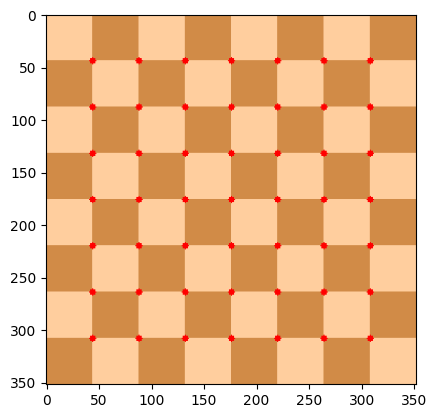

In [ ]:
for i in corners:
    x,y = i.ravel()
    cv2.circle(flatChess, (x,y), 3, (255,0,0), -1)
    
plt.imshow(flatChess)

### Canny Edge Detection

In [ ]:
img = cv2.imread("W:/Advanced Engineering/Vortex Ballistics/~ACTIVE/Python Script/DATA/sammy_face.jpg")
blurImg = cv2.blur(img, ksize=(5,5))

In [ ]:
#general formula for setting thresholds when edge detecting. May still need to change
lower = int(max(0,.7*np.median(img)))
upper = int(min(255,1.3*np.median(img)))

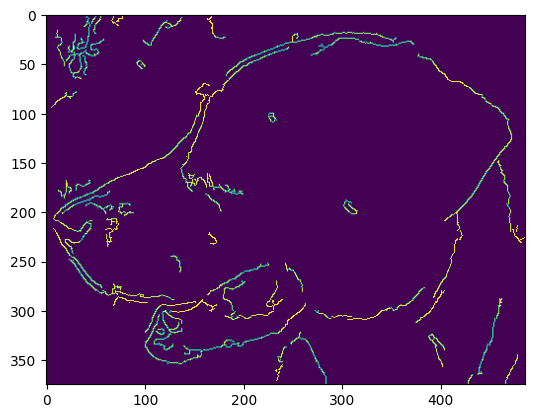

In [ ]:
#usually need to blur images before thresholding
edges = cv2.Canny(image= blurImg, threshold1 = lower, threshold2 = upper+100)
plt.imshow(edges)

### Contour Detection

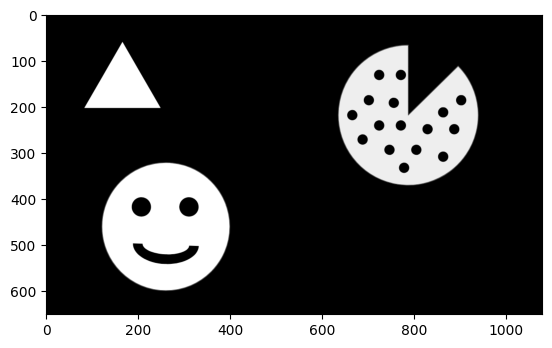

In [ ]:
img = cv2.imread("W:/Advanced Engineering/Vortex Ballistics/~ACTIVE/Python Script/DATA/internal_external.png", 0)
plt.imshow(img, cmap='gray')

In [ ]:
contours, hierarchy = cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
hierarchy

array([[[ 4, -1,  1, -1],
        [ 2, -1, -1,  0],
        [ 3,  1, -1,  0],
        [-1,  2, -1,  0],
        [21,  0,  5, -1],
        [ 6, -1, -1,  4],
        [ 7,  5, -1,  4],
        [ 8,  6, -1,  4],
        [ 9,  7, -1,  4],
        [10,  8, -1,  4],
        [11,  9, -1,  4],
        [12, 10, -1,  4],
        [13, 11, -1,  4],
        [14, 12, -1,  4],
        [15, 13, -1,  4],
        [16, 14, -1,  4],
        [17, 15, -1,  4],
        [18, 16, -1,  4],
        [19, 17, -1,  4],
        [20, 18, -1,  4],
        [-1, 19, -1,  4],
        [-1,  4, -1, -1]]], dtype=int32)

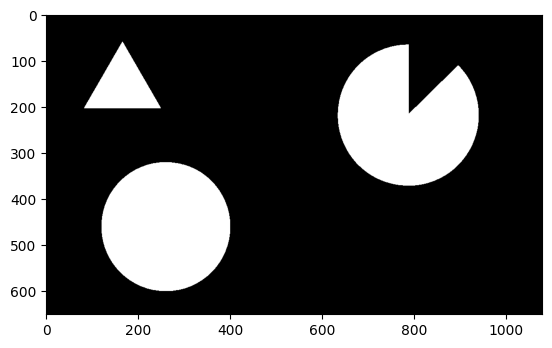

In [ ]:
extCont = np.zeros(img.shape)

for i in range(len(contours)):
    #find external contours only
    if hierarchy[0][i][3] == -1:
        cv2.drawContours(extCont, contours,i,255,-1)
        
plt.imshow(extCont, cmap='gray')

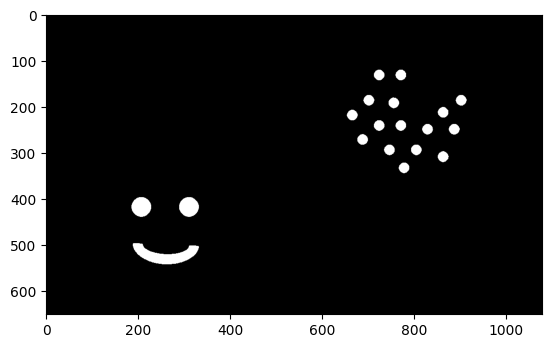

In [ ]:
intCont = np.zeros(img.shape)

for i in range(len(contours)):
    #find internal contours only
    if hierarchy[0][i][3] != -1:
        #if set == 0 then we only get internal for smiley
        #if set == 4 we get internal for pizza
        cv2.drawContours(intCont, contours,i,255,-1)
        
plt.imshow(intCont, cmap='gray')

### Feature Matching

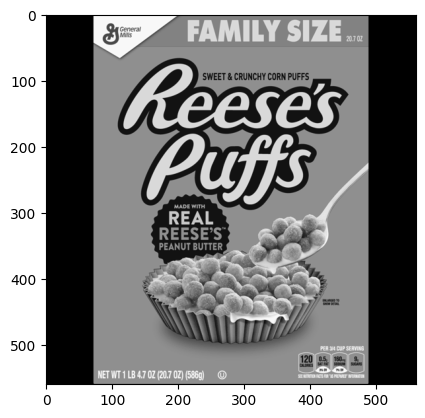

In [ ]:
reeses = cv2.imread("W:/Advanced Engineering/Vortex Ballistics/~ACTIVE/Python Script/DATA/reeses_puffs.png", 0)
plt.imshow(reeses, cmap = 'gray')

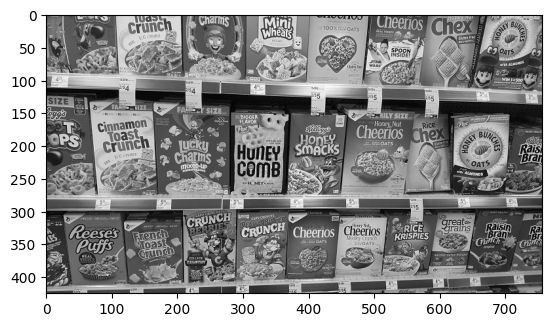

In [ ]:
cereals = cv2.imread("W:/Advanced Engineering/Vortex Ballistics/~ACTIVE/Python Script/DATA/many_cereals.jpg", 0)
plt.imshow(cereals, cmap = 'gray')

##### Brute Force Detection with ORB Detectors

In [ ]:
orb = cv2.ORB_create()
#create key points and descriptors from both images
kp1, des1 = orb.detectAndCompute(reeses, None)
kp2, des2 = orb.detectAndCompute(cereals, None)

In [ ]:
#create brute force object and check matches between descriptors of both images
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)

In [ ]:
#sorting matches by distance (how good of a match it is)
matches = sorted(matches, key=lambda x:x.distance)

In [ ]:
#only using first 25 to limit to best sorted
reesesMatches = cv2.drawMatches(reeses, kp1, cereals, kp2, matches[:25], None, flags=2)

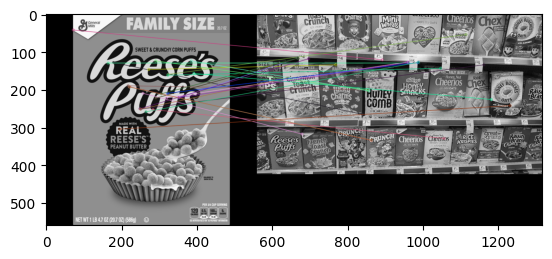

In [ ]:
plt.imshow(reesesMatches)

##### Brute Force Detection with SIFT Detectors

In [ ]:
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(reeses,None)
kp2, des2 = sift.detectAndCompute(cereals,None)

In [ ]:
bf = cv2.BFMatcher()

In [ ]:
#find best pairs of (k=2) matches based on descriptors
matches = bf.knnMatch(des1, des2, k=2)

In [ ]:
good = []

#LESS DISTANCE == BETTER MATCH

#Ratio Match 1 < 75% Match 2
for match1,match2 in matches:
    if match1.distance < 0.75*match2.distance:
        good.append([match1])

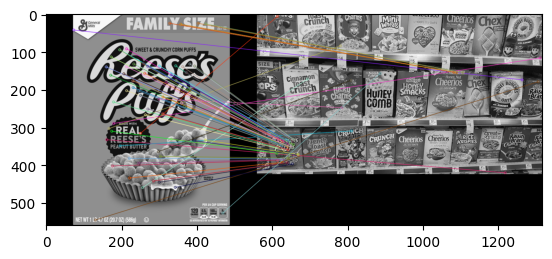

In [ ]:
siftMatches = cv2.drawMatchesKnn(reeses, kp1, cereals, kp2, good, None, flags=2)
plt.imshow(siftMatches)

##### FLANN Based Matching - faster but less accurate

In [ ]:
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(reeses,None)
kp2, des2 = sift.detectAndCompute(cereals,None)

In [ ]:
#FLANN Parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

In [ ]:
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

In [ ]:
matchesMask = [[0,0] for i in range(len(matches))]

In [ ]:
# good = []
# for match1, match2 in matches:
#     if match1.distance < 0.7*match2.distance:
#         good.append([match1])

for i, (match1, match2) in enumerate(matches):
    if match1.distance < 0.7*match2.distance:
        matchesMask[i] = [1,0]
        
draw_params = dict(matchColor = (0,255,0),
                  singlePointColor = (255,0,0),
                  matchesMask = matchesMask,
                  flags = 0)

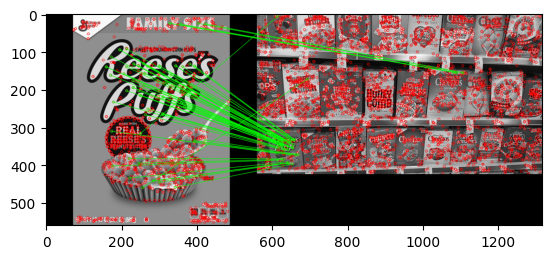

In [ ]:
flannMatches = cv2.drawMatchesKnn(reeses, kp1, cereals, kp2, matches, None, **draw_params)
plt.imshow(flannMatches)

### Watershed

##### Automatic Seeding

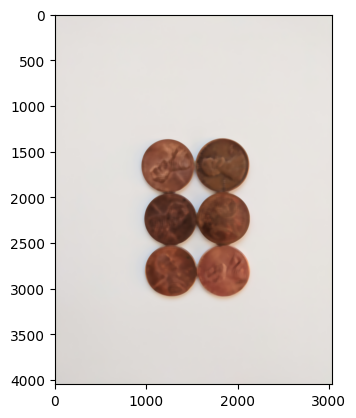

In [ ]:
#sepCoins = cv2.imread("W:/Advanced Engineering/Vortex Ballistics/~ACTIVE/Python Script/DATA/pennies.jpg")
#sepCoins = cv2.imread("W:\Advanced Engineering\Vortex Ballistics\Gel Images\IMG_0470.JPG")
sepCoins = cv2.imread("W:\Advanced Engineering\Vortex Ballistics\~ACTIVE\Python Script\DATA\pennies.jpg")
sepCoins = cv2.cvtColor(sepCoins, cv2.COLOR_BGR2RGB)
#blur to ensure that edges are actually picked up
img = cv2.medianBlur(sepCoins,35)
plt.imshow(img)

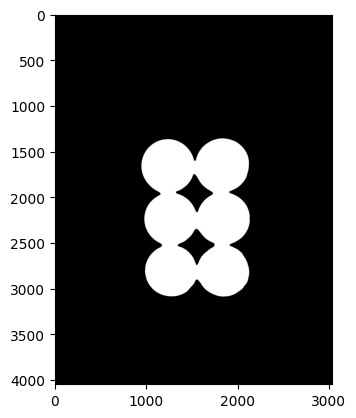

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#thresh otsu helps threshold the binary without manually inputting a lower bound
#and ensures we get the entire image
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.imshow(thresh, cmap='gray')

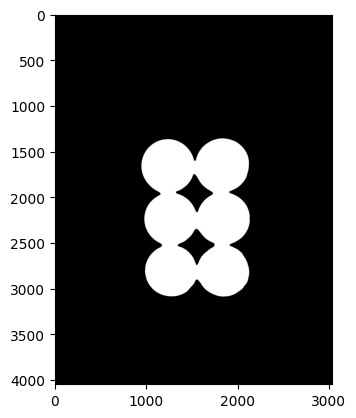

In [ ]:
#NOISE REMOVAL
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
plt.imshow(opening, cmap='gray')

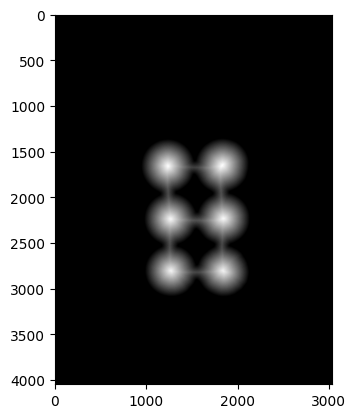

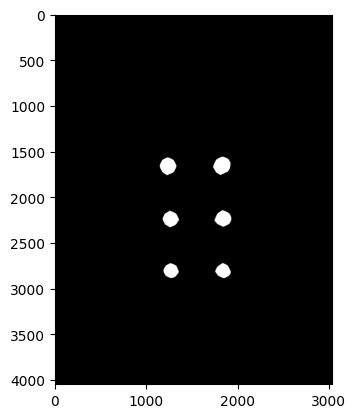

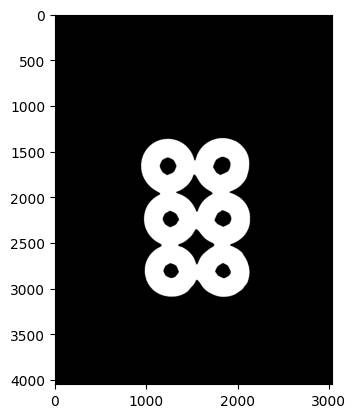

In [ ]:
#calculate the definite background of the image
sure_bg = cv2.dilate(opening, kernel, iterations = 3)

#calculate the defininte foreground of the image using distanceTransform
#distanceTransform makes the points furthest away from black a lot brighter than white points close to black
distTrans = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
plt.imshow(distTrans, cmap='gray')
plt.show()
ret, sure_fg = cv2.threshold(distTrans, 0.7*distTrans.max(), 255, 0)
plt.imshow(sure_fg, cmap='gray')
plt.show()

#calculate unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)
plt.imshow(unknown, cmap='gray')

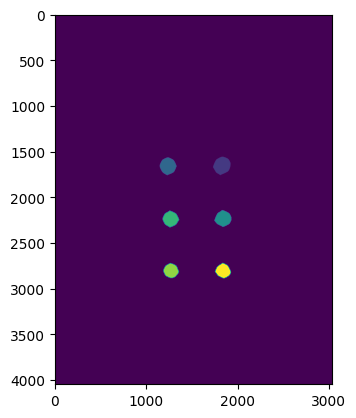

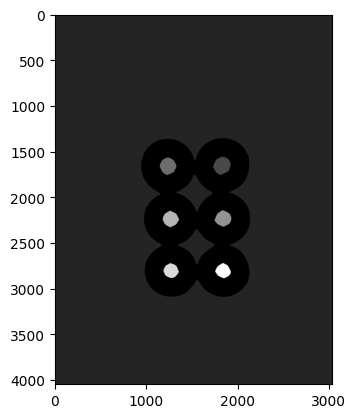

In [ ]:
ret, markers = cv2.connectedComponents(sure_fg)
plt.imshow(markers)
plt.show()
#makes background diff color than unknown
markers = markers+1
markers[unknown==255] = 0
plt.imshow(markers, cmap='gray')

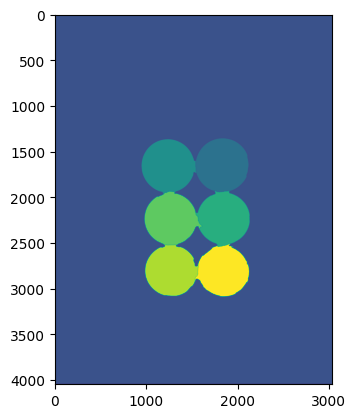

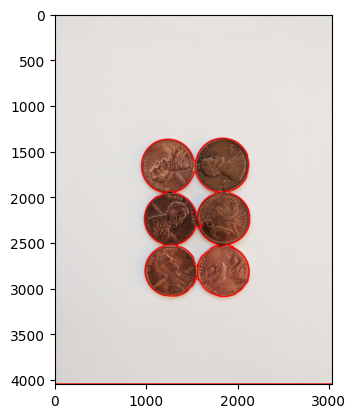

In [ ]:
markers = cv2.watershed(img, markers)
plt.imshow(markers)
plt.show()
contours, hierarchy = cv2.findContours(markers.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
#print(hierarchy)

for i in range(len(contours)):
    if hierarchy[0][i][3] == -1:
        cv2.drawContours(sepCoins, contours, i, (255,0,0), 10)
        
plt.imshow(sepCoins)

##### Custom Seeding

In [ ]:
road = cv2.imread("W:\Advanced Engineering\Vortex Ballistics\Gel Images\IMG_0470.JPG")
road = cv2.resize(road, (int(road.shape[1]/10), int(road.shape[0]/10)))
road_copy = np.copy(road)

In [ ]:
marker_image = np.zeros(road.shape[:2], dtype=np.int32)
segments = np.zeros(road.shape, dtype=np.uint8)

In [ ]:
#pick color map for different seeds based on tab10
def create_rgb(i):
    return tuple(np.array(cm.tab10(i)[:3])*255)

In [ ]:
colors = []
for i in range(10):
    colors.append(create_rgb(i))

In [ ]:
#GlOBAL VARIABLES
current_marker = 1
lastMarker = 1
marks_updated = False
n_markers = 10
lastMarkerImg = marker_image.copy()
lastRoad = road_copy.copy()

In [ ]:
#CALLBACK FUNCTION
def mouse_callback(event, x, y, flags, param):
    global marks_updated
    global lastRoad
    global lastMarkerImg
    
    if event == cv2.EVENT_LBUTTONDOWN:
        lastRoad = np.copy(road_copy)
        lastMarkerImg = np.copy(marker_image)
        #circle passed to watershed
        cv2.circle(marker_image, (x,y), 4, (current_marker), -1)
        
        #user visual
        cv2.circle(road_copy, (x,y), 4, colors[current_marker], -1)
        
        marks_updated = True

In [ ]:
road_copy = road.copy()
marker_image = np.zeros(road.shape[:2], dtype=np.int32)
segments = np.zeros(road.shape, dtype=np.uint8)
lastMarkerImg = marker_image.copy()
lastRoad = road.copy()


cv2.namedWindow('Road Image')
cv2.setMouseCallback('Road Image', mouse_callback)

while True:
    cv2.imshow('Watershed Segments', segments)
    cv2.imshow('Road Image', road_copy)
    
    #Close all Windows
    k = cv2.waitKey(1)
    
    if k == 27:
        break
     
    #clear all markers placed if 'c' is pressed
    elif k == ord('c'):
        road_copy = road.copy()
        marker_image = np.zeros(road.shape[:2], dtype = np.int32)
        segments = np.zeros(road.shape, dtype=np.uint8)
    
    #Update Color Choice
    elif k> 0 and chr(k).isdigit():
        lastMarker = current_marker
        current_marker = int(chr(k))
        
    elif k == ord('s'):
        outImg = segments.copy()
        
    elif k == 8:
        road_copy = lastRoad
        marker_image = lastMarkerImg
        
        marker_image_copy = marker_image.copy()
        cv2.watershed(road, marker_image_copy)
        
        segments = np.zeros(road.shape, dtype=np.uint8)
        
        for color_ind in range(n_markers):
            segments[marker_image_copy == (color_ind)] = colors[color_ind]
        
    #Update marking
    if marks_updated:
        marker_image_copy = marker_image.copy()
        cv2.watershed(road, marker_image_copy)
        
        segments = np.zeros(road.shape, dtype=np.uint8)
        
        for color_ind in range(n_markers):
            segments[marker_image_copy == (color_ind)] = colors[color_ind]
        
cv2.destroyAllWindows()

### Face Detection

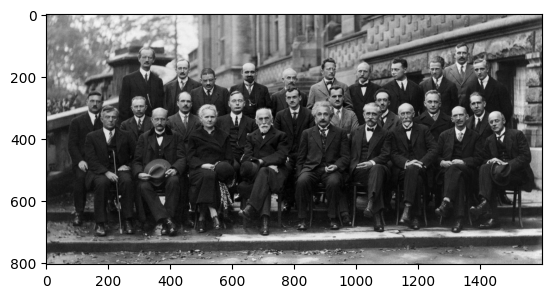

In [ ]:
nadia = cv2.imread("W:/Advanced Engineering/Vortex Ballistics/~ACTIVE/Python Script/DATA/Nadia_Murad.jpg", 0)
dennis = cv2.imread("W:/Advanced Engineering/Vortex Ballistics/~ACTIVE/Python Script/DATA/Denis_Mukwege.jpg", 0)
solvay = cv2.imread("W:/Advanced Engineering/Vortex Ballistics/~ACTIVE/Python Script/DATA/solvay_conference.jpg", 0)
plt.imshow(solvay, cmap='gray')

In [ ]:
#use pre-trained cascades here classifier. The pretrained is an xml file
#these are features that indicate the presence of a face
faceCascade = cv2.CascadeClassifier('DATA/haarcascades/haarcascade_frontalface_default.xml')

In [ ]:
def detect_face(img):
    faceImg = img.copy()
    faceRect = faceCascade.detectMultiScale(faceImg)
    
    for (x,y,w,h) in faceRect:
        cv2.rectangle(faceImg, (x,y), (x+w,y+h), (255,255,255), 10)
        
    return faceImg

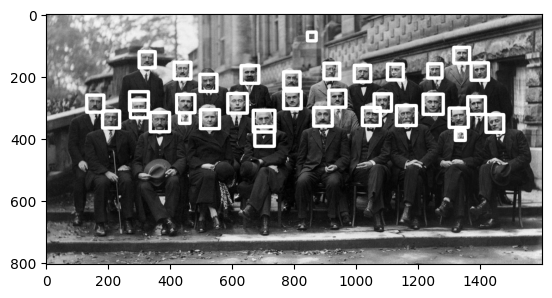

In [ ]:
plt.imshow(detect_face(solvay), cmap='gray')

In [ ]:
def adj_detect_face(img):
    faceImg = img.copy()
    #more than 1 rectange actually detect a face, so need a min of 5 rectangles to say this is a face
    #to draw the rectangle on there
    faceRect = faceCascade.detectMultiScale(faceImg, scaleFactor = 1.2, minNeighbors = 5)
    
    for (x,y,w,h) in faceRect:
        cv2.rectangle(faceImg, (x,y), (x+w,y+h), (255,255,255), 10)
        
    return faceImg 

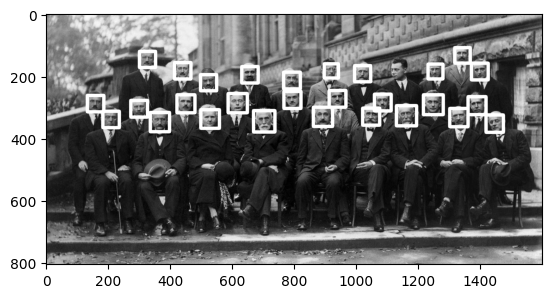

In [ ]:
plt.imshow(adj_detect_face(solvay), cmap='gray')

### ML with Keras and Deep Learning- Dense Neural Network

In [ ]:
from numpy import genfromtxt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from tensorflow.keras.layers import Dense
import torch
import sklearn
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# has 4 columns of features and last col indicates real or fake banknote
data = genfromtxt('DATA/bank_note_data.txt', delimiter=",")
labels = data[:,4]
features = data[:,0:4]
#general notations
X = features
y = labels

In [ ]:
#pass features, labels, 33% is in test set, random state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
#standardize data to ensure everything from 0-1 between the 4 features
scalerObject = MinMaxScaler()

#only scale on train set so that it can't look at test data
#use scale from train data to scale test data
scalerObject.fit(X_train)
#scale the train and test sets
scaledXTrain = scalerObject.transform(X_train)
scaledXTest = scalerObject.transform(X_test)

In [ ]:
y_test

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1.,
       1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0.,
       1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 0., 1., 0.

In [ ]:
model = Sequential()

model.add(Dense(4, input_dim=4, activation='relu'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [ ]:
model.fit(scaledXTrain, y_train, epochs=50, verbose=2)

Epoch 1/50


29/29 - 1s - loss: 0.7324 - accuracy: 0.3863 - 684ms/epoch - 24ms/step
Epoch 2/50
29/29 - 0s - loss: 0.7067 - accuracy: 0.3243 - 35ms/epoch - 1ms/step
Epoch 3/50
29/29 - 0s - loss: 0.6946 - accuracy: 0.5484 - 40ms/epoch - 1ms/step
Epoch 4/50
29/29 - 0s - loss: 0.6882 - accuracy: 0.5495 - 34ms/epoch - 1ms/step
Epoch 5/50
29/29 - 0s - loss: 0.6838 - accuracy: 0.5495 - 31ms/epoch - 1ms/step
Epoch 6/50
29/29 - 0s - loss: 0.6804 - accuracy: 0.5495 - 30ms/epoch - 1ms/step
Epoch 7/50
29/29 - 0s - loss: 0.6773 - accuracy: 0.5495 - 29ms/epoch - 1ms/step
Epoch 8/50
29/29 - 0s - loss: 0.6742 - accuracy: 0.5495 - 32ms/epoch - 1ms/step
Epoch 9/50
29/29 - 0s - loss: 0.6701 - accuracy: 0.5495 - 28ms/epoch - 975us/step
Epoch 10/50
29/29 - 0s - loss: 0.6661 - accuracy: 0.5495 - 30ms/epoch - 1ms/step
Epoch 11/50
29/29 - 0s - loss: 0.6617 - accuracy: 0.5495 - 32ms/epoch - 1ms/step
Epoch 12/50
29/29 - 0s - loss: 0.6561 - accuracy: 0.5495 - 34ms/epoch - 1ms/step
Epoch 13/50
29/29 - 0s - loss: 0.6498 - accu

In [ ]:
#use for binary classification 
predictions = (model.predict(X_test) > 0.5).astype("int32")
#The line below is for sigmoidal classification
#predictions = np.argmax(model.predict(X_test),axis=1)
predictions

15/15 [==============================] - 0s 1ms/step


array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
    

In [ ]:
confusion_matrix(y_test, predictions)

array([[257,   0],
       [ 53, 143]], dtype=int64)

In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91       257
         1.0       1.00      0.73      0.84       196

    accuracy                           0.88       453
   macro avg       0.91      0.86      0.88       453
weighted avg       0.90      0.88      0.88       453



### Convolutional Neural Networks with MNIST

In [ ]:
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout

In [ ]:
path = '/tmp/data/mnist.npz'
(xTrain, yTrain) , (xTest, yTest) = tf.keras.datasets.mnist.load_data("C:/Users/naresh/Downloads/mnist.npz")

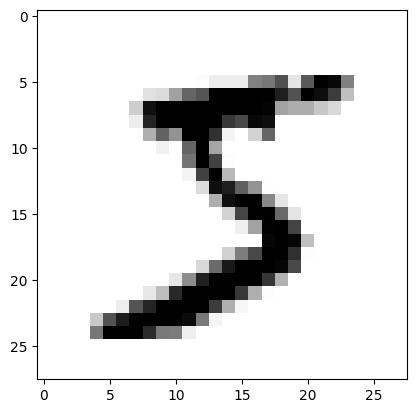

In [ ]:
xTrain.shape
plt.imshow(xTrain[0], cmap='gray_r')

In [ ]:
yTrain

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [ ]:
#one hot coding the data from above
yCatTest = to_categorical(yTest, 10)
yCatTrain = to_categorical(yTrain, 10)

In [ ]:
yCatTrain[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [ ]:
xTrain = xTrain/xTrain.max()
xTest = xTest/xTest.max()

In [ ]:
xTrain = xTrain.reshape(xTrain.shape[0], xTrain.shape[1], xTrain.shape[2], 1)
xTrain.shape
xTest = xTest.reshape(xTest.shape[0], xTest.shape[1], xTest.shape[2], 1)
xTest.shape

(10000, 28, 28, 1)

In [ ]:
model = Sequential()

#Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=(4,4), input_shape=(xTest.shape[1], xTest.shape[2], xTest.shape[3]), activation='relu'))
#Pooling Layer
model.add(MaxPool2D(pool_size=(2,2)))
#flattening 2d -> 1d since 2d image to 1d hotmap
model.add(Flatten())
#Dense LAyer
model.add(Dense(128, activation='relu'))
#output
model.add(Dense(10,activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        544       
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               589952    
                                                                 
 dense_4 (Dense)             (None, 10)                1290      
                                                                 
Total params: 591786 (2.26 MB)
Trainable params: 591786 (2.26 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [ ]:
model.fit(xTrain, yCatTrain, epochs=2)

Epoch 1/2
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1404 - accuracy: 0.9581
Epoch 2/2
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0462 - accuracy: 0.9856


In [ ]:
model.evaluate(xTest, yCatTest)

313/313 [==============================] - 1s 2ms/step - loss: 0.0454 - accuracy: 0.9854


[0.0454440675675869, 0.9854000210762024]

In [ ]:
prediction = (model.predict(xTest) > 0.5).astype("int32")
prediction

313/313 [==============================] - 1s 2ms/step


array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
print(classification_report(yCatTest, prediction))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      0.96      0.98      1032
           3       0.98      0.99      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.98      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.96      0.99      0.97       974
           9       0.99      0.97      0.98      1009

   micro avg       0.99      0.98      0.99     10000
   macro avg       0.99      0.98      0.99     10000
weighted avg       0.99      0.98      0.99     10000
 samples avg       0.98      0.98      0.98     10000



C:\Users\naresh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Classifying Color Images

In [ ]:
from keras.datasets import cifar10

In [ ]:
(xTrain, yTrain), (xTest, yTest) = cifar10.load_data()

(50000, 32, 32, 3)


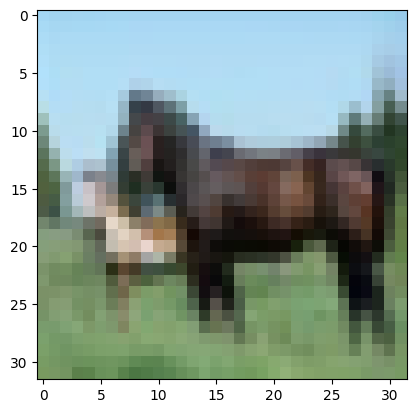

In [ ]:
print(xTrain.shape)
plt.imshow(xTrain[12])

In [ ]:
xTrain = xTrain/xTrain.max()
xTest = xTest/xTrain.max()

In [ ]:
yCatTrain = to_categorical(yTrain, 10)
yCatTest = to_categorical(yTest, 10)

In [ ]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size=(4,4), input_shape = (xTrain.shape[1], xTrain.shape[2], xTrain.shape[3]), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size=(4,4), input_shape = (xTrain.shape[1], xTrain.shape[2], xTrain.shape[3]), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))

model.add(Dense(10,activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 29, 29, 32)        1568      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 32)        16416     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 5, 5, 32)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 800)               0         
                                                                 
 dense_5 (Dense)             (None, 256)              

In [ ]:
model.fit(xTrain, yCatTrain, verbose=1, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 20s 12ms/step - loss: 1.5696 - accuracy: 0.4354
Epoch 2/10
1563/1563 [==============================] - 19s 12ms/step - loss: 1.2155 - accuracy: 0.5700
Epoch 3/10
1563/1563 [==============================] - 20s 13ms/step - loss: 1.0631 - accuracy: 0.6291
Epoch 4/10
1563/1563 [==============================] - 19s 12ms/step - loss: 0.9522 - accuracy: 0.6697
Epoch 5/10
1563/1563 [==============================] - 18s 12ms/step - loss: 0.8629 - accuracy: 0.7010
Epoch 6/10
1563/1563 [==============================] - 18s 12ms/step - loss: 0.7942 - accuracy: 0.7293
Epoch 7/10
1563/1563 [==============================] - 18s 12ms/step - loss: 0.7377 - accuracy: 0.7485
Epoch 8/10
1563/1563 [==============================] - 19s 12ms/step - loss: 0.6887 - accuracy: 0.7657
Epoch 9/10
1563/1563 [==============================] - 18s 12ms/step - loss: 0.6440 - accuracy: 0.7806
Epoch 10/10
1563/1563 [==============================] - 18s 12m

In [ ]:
model.evaluate(xTest, yCatTest)

313/313 [==============================] - 1s 3ms/step - loss: 270.7085 - accuracy: 0.5061


[270.7084655761719, 0.5060999989509583]

In [ ]:
prediction = (model.predict(xTest) > 0.5).astype("int32")
prediction
print(classification_report(yCatTest, prediction))

313/313 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.41      0.81      0.54      1000
           1       0.49      0.79      0.60      1000
           2       0.65      0.18      0.28      1000
           3       0.45      0.28      0.34      1000
           4       0.69      0.15      0.25      1000
           5       0.42      0.60      0.49      1000
           6       0.84      0.36      0.51      1000
           7       0.42      0.77      0.55      1000
           8       0.70      0.52      0.60      1000
           9       0.69      0.60      0.64      1000

   micro avg       0.51      0.51      0.51     10000
   macro avg       0.58      0.51      0.48     10000
weighted avg       0.58      0.51      0.48     10000
 samples avg       0.51      0.51      0.51     10000



### Deep Learning and Keras on actual images

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

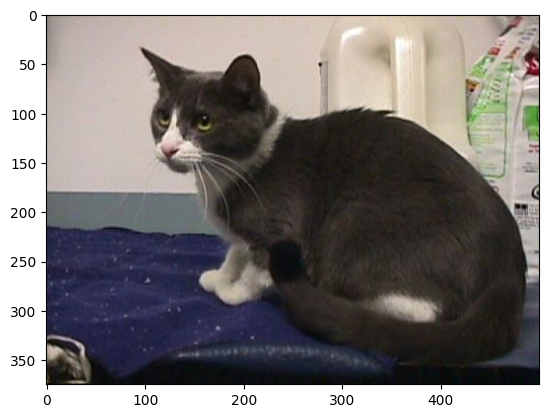

In [4]:
cat4 = cv2.imread("C:/Users/naresh/Downloads/CATS_DOGS/CATS_DOGS/train/CAT/4.jpg")
cat4 = cv2.cvtColor(cat4, cv2.COLOR_BGR2RGB)
plt.imshow(cat4)

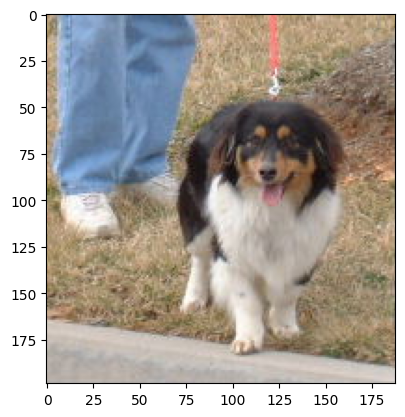

In [5]:
dog = cv2.imread("C:/Users/naresh/Downloads/CATS_DOGS/CATS_DOGS/train/DOG/2.jpg")
dog = cv2.cvtColor(dog, cv2.COLOR_BGR2RGB)
plt.imshow(dog)

In [9]:
imageGen = ImageDataGenerator(#rotation_range=30,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              rescale=1/255,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              fill_mode='nearest'
                              )

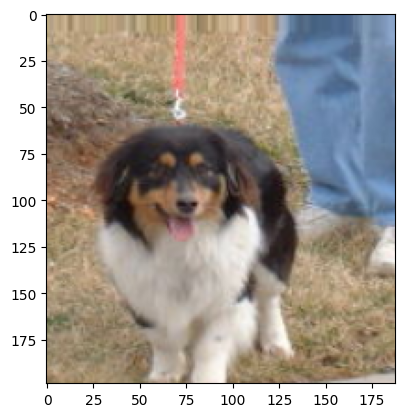

In [16]:
plt.imshow(imageGen.random_transform(dog))

In [205]:
imageGen.flow_from_directory("C:/Users/naresh/Downloads/CATS_DOGS/CATS_DOGS/train")

Found 18743 images belonging to 2 classes.


In [206]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(150,150,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(150,150,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(150,150,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
#precents overfitting by only activating .5 of the neurons in the model per run
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [207]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 36, 36, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 34, 34, 32)        9248      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 17, 17, 32)       

In [209]:
batchSize = 16

trainImageGen = imageGen.flow_from_directory("C:/Users/naresh/Downloads/CATS_DOGS/CATS_DOGS/train",
                                             target_size=(150,150),
                                             batch_size= batchSize,
                                             class_mode='binary')

testImageGen = imageGen.flow_from_directory("C:/Users/naresh/Downloads/CATS_DOGS/CATS_DOGS/test",
                                            target_size=(150,150),
                                            batch_size=batchSize,
                                            class_mode='binary')

trainImageGen.class_indices

Found 18743 images belonging to 2 classes.
Found 6251 images belonging to 2 classes.


{'CAT': 0, 'DOG': 1}

In [222]:
results = model.fit(trainImageGen, epochs = 100, steps_per_epoch=150, validation_data=testImageGen, validation_steps=12)

Epoch 1/100
150/150 [==============================] - 76s 509ms/step - loss: 0.5555 - accuracy: 0.7117 - val_loss: 0.5559 - val_accuracy: 0.7292
Epoch 2/100
150/150 [==============================] - 101s 677ms/step - loss: 0.5484 - accuracy: 0.7265 - val_loss: 0.4986 - val_accuracy: 0.7760
Epoch 3/100
150/150 [==============================] - 34s 224ms/step - loss: 0.5273 - accuracy: 0.7446 - val_loss: 0.5038 - val_accuracy: 0.7604
Epoch 4/100
129/150 [========================>.....] - ETA: 30s - loss: 0.5275 - accuracy: 0.7447

C:\Users\naresh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\PIL\TiffImagePlugin.py:866: UserWarning: Truncated File Read
  warnings.warn(str(msg))


150/150 [==============================] - 191s 1s/step - loss: 0.5221 - accuracy: 0.7458 - val_loss: 0.4557 - val_accuracy: 0.7865
Epoch 5/100
150/150 [==============================] - 4266s 29s/step - loss: 0.5224 - accuracy: 0.7483 - val_loss: 0.5615 - val_accuracy: 0.6979
Epoch 6/100
150/150 [==============================] - 25s 163ms/step - loss: 0.5434 - accuracy: 0.7250 - val_loss: 0.6017 - val_accuracy: 0.7240
Epoch 7/100
150/150 [==============================] - 24s 162ms/step - loss: 0.5201 - accuracy: 0.7563 - val_loss: 0.4607 - val_accuracy: 0.7812
Epoch 8/100
150/150 [==============================] - 24s 156ms/step - loss: 0.5312 - accuracy: 0.7382 - val_loss: 0.4967 - val_accuracy: 0.7344
Epoch 9/100
150/150 [==============================] - 24s 160ms/step - loss: 0.5349 - accuracy: 0.7392 - val_loss: 0.5082 - val_accuracy: 0.7760
Epoch 10/100
150/150 [==============================] - 24s 163ms/step - loss: 0.5280 - accuracy: 0.7454 - val_loss: 0.5127 - val_accuracy

In [213]:
type(model)

keras.src.engine.sequential.Sequential

In [219]:
### Testin model on new unseen images
dogFile = "C:/Users/naresh/Downloads/CATS_DOGS/CATS_DOGS/test/DOG/10005.jpg"
dogImg = image.load_img(dogFile, target_size=(150,150))
dogImg = image.img_to_array(dogImg)
dogImg.shape

(150, 150, 3)

In [220]:
dogImg = np.expand_dims(dogImg, axis=0)
dogImg = dogImg/255
dogImg.shape

(1, 150, 150, 3)

In [221]:
model.predict(dogImg)

1/1 [==============================] - 0s 90ms/step


array([[0.690887]], dtype=float32)